In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat

In [13]:
cuda = 'gpu:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(cuda)
print(torch.cuda.is_available())

False


In [16]:
# Load MAT Data Files

matpath_upper = "/Volumes/RESEARCH1/CAOS/_data/Training/psiTrain/psiTrain1_30km.mat"
matpath_mid = "/Volumes/RESEARCH1/CAOS/_data/Training/psiTrain/psiTrain1_30km_mid.mat"

psi1_upper = loadmat(matpath_upper)
psi1_mid = loadmat(matpath_mid)

psi1_upper_30km_filter = psi1_upper['psi1_30km'].astype(np.float64)
psi1_upper_anomaly = psi1_upper['psi1Anom'].astype(np.float64)
psi1_upper_unfiltered = psi1_upper_30km_filter + psi1_upper_anomaly

psi1_mid_unfiltered = psi1_mid['psi1_mid'].astype(np.float64)
psi1_top_30km = psi1_mid['psi1_top_30km'].astype(np.float64)

In [17]:
class psi1_Dataset:
    """psiTrain 30km mid Dataset."""

    def __init__(self, X, Y, is_train, train_split):
        n_total_samples = len(X[0, 0, :])
        split_idx = int(np.floor(train_split * n_total_samples))

        x_train = X[:, :, :split_idx]
        y_train = Y[:, :, :split_idx]

        x_test = X[:, :, split_idx:]
        y_test = Y[:, :, split_idx:]

        # Differentiate Train v. Test & Normalize
        
        x_mean, x_std = x_train.mean(), x_train.std()
        y_mean, y_std = y_train.mean(), y_train.std()
        
        if is_train:
            self.x = (x_train - x_mean) / x_std
            self.y = (y_train - y_mean) / y_std
        else:
            self.x = (x_test - x_mean) / x_std
            self.y = (y_test - y_mean) / y_std
        
    def __len__(self):
        return len(self.x[0, 0, :])

    def __getitem__(self, idx):
        if torch.is_tensor(idx): idx = idx.tolist()        
        return self.x[:, :, idx], self.y[:, :, idx]

In [18]:
batch_size = 64
train_split = 0.888888
shuffle_flag = True

# Create Train/Test datasets

train_dataset = psi1_Dataset(X = psi1_upper_30km_filter,
                             Y = psi1_upper_anomaly,
                             is_train = True,
                             train_split = train_split)

test_dataset  = psi1_Dataset(X = psi1_upper_30km_filter,
                             Y = psi1_upper_anomaly,
                             is_train = False,
                             train_split = train_split)


# Create Data Loaders

train_loader = DataLoader(train_dataset,
                          batch_size = batch_size,
                          shuffle = shuffle_flag)

test_loader  = DataLoader(test_dataset,
                          batch_size = batch_size,
                          shuffle = shuffle_flag)

In [19]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        
        super(CNN, self).__init__()
        
        bias_flag = True
        
        self.conv1 = nn.Conv2d( in_channels = 1,   out_channels = 128, kernel_size = 3, bias = bias_flag, padding = 1 )
        self.conv2 = nn.Conv2d( in_channels = 128, out_channels = 64,  kernel_size = 3, bias = bias_flag, padding = 1 )
        self.conv3 = nn.Conv2d( in_channels = 64,  out_channels = 48,  kernel_size = 3, bias = bias_flag, padding = 1 )
        self.conv4 = nn.Conv2d( in_channels = 48,  out_channels = 1,   kernel_size = 3, bias = bias_flag, padding = 1 )
        
#         # Experimental - Fixed kernel layer
#         f = np.random.rand(5, 5).astype(np.float32)
#         f = f.reshape(1, 1, f.shape[0], f.shape[1])
#         f = np.repeat(f, 100, axis=1)
#         f = np.repeat(f, 100, axis=0)
#         self.f = nn.Parameter(data=torch.FloatTensor(f), requires_grad=False)
#         self.conv4 = nn.conv2d(x, self.f)
    
        self.conv1_bn = nn.BatchNorm2d(128)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3_bn = nn.BatchNorm2d(48)

    def forward(self, X, verbose = False):
        X = F.selu(self.conv1(X))
        X = self.conv1_bn(X)
        
        X = F.selu(self.conv2(X))
        X = self.conv2_bn(X)

        X = F.selu(self.conv3(X))
        X = self.conv3_bn(X)
        
        return self.conv4(X)

In [23]:
training_loss_list = []


def get_n_params(model):
    n = 0
    for p in list(model.parameters()):
        n += p.nelement()
    return n

def print_progress(epoch, batch_idx, data, train_loader, loss):
    training_loss_list.append(loss.item())
    if batch_idx % 1 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tMSE Loss: {:.6f}'.format(epoch,
                                                                           batch_idx * len(data),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss.item()))

In [34]:
def train(epoch, model, train_loader):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.float().to(device)
        data = data.view(-1, 1, 160, 160)
        
        target = target.float().to(device)
        target = target.view(-1, 1, 160, 160)
        
        #BACKPROP STEP
        output = model(data)
        loss = F.mse_loss(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print_progress(epoch, batch_idx, data, train_loader, loss)
            
            
def test(model, test_loader):
    model.eval()
    test_loss = 0
    n_samples = len(test_loader.dataset)
    
    for data, target in test_loader:
        data = data.float().to(device)
        data = data.view(-1, 1, 160, 160)

        target = target.float().to(device) 
        target = target.view(-1, 1, 160, 160)
        
        output = model(data)
        test_loss += F.mse_loss(output, target).item() # sum up batch loss      

    test_loss /= n_samples

    print('\nTest set: Average loss: {:.4f}'.format(test_loss))


In [25]:
n_epochs = 1000
input_size = 160 * 160
output_size = 160 * 160

model_cnn = CNN(input_size, output_size)
model_cnn.float().to(device)
optimizer = optim.Adam(model_cnn.parameters(), lr = 0.0001)

print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(n_epochs): train(epoch, model_cnn, train_loader)

Number of parameters: 103681
Train Epoch: 0 [0/3244 (0%)]	MSE Loss: 1.101552
Train Epoch: 0 [64/3244 (2%)]	MSE Loss: 0.859136
Train Epoch: 0 [128/3244 (4%)]	MSE Loss: 0.824153
Train Epoch: 0 [192/3244 (6%)]	MSE Loss: 0.779865
Train Epoch: 0 [256/3244 (8%)]	MSE Loss: 0.736399
Train Epoch: 0 [320/3244 (10%)]	MSE Loss: 0.716210
Train Epoch: 0 [384/3244 (12%)]	MSE Loss: 0.705513
Train Epoch: 0 [448/3244 (14%)]	MSE Loss: 0.693554
Train Epoch: 0 [512/3244 (16%)]	MSE Loss: 0.672866
Train Epoch: 0 [576/3244 (18%)]	MSE Loss: 0.644211
Train Epoch: 0 [640/3244 (20%)]	MSE Loss: 0.638354
Train Epoch: 0 [704/3244 (22%)]	MSE Loss: 0.629151
Train Epoch: 0 [768/3244 (24%)]	MSE Loss: 0.590493
Train Epoch: 0 [832/3244 (25%)]	MSE Loss: 0.580375
Train Epoch: 0 [896/3244 (27%)]	MSE Loss: 0.576244
Train Epoch: 0 [960/3244 (29%)]	MSE Loss: 0.559963
Train Epoch: 0 [1024/3244 (31%)]	MSE Loss: 0.531471
Train Epoch: 0 [1088/3244 (33%)]	MSE Loss: 0.511189
Train Epoch: 0 [1152/3244 (35%)]	MSE Loss: 0.513271
Train E

Train Epoch: 3 [384/3244 (12%)]	MSE Loss: 0.065660
Train Epoch: 3 [448/3244 (14%)]	MSE Loss: 0.054257
Train Epoch: 3 [512/3244 (16%)]	MSE Loss: 0.073680
Train Epoch: 3 [576/3244 (18%)]	MSE Loss: 0.072542
Train Epoch: 3 [640/3244 (20%)]	MSE Loss: 0.061340
Train Epoch: 3 [704/3244 (22%)]	MSE Loss: 0.071683
Train Epoch: 3 [768/3244 (24%)]	MSE Loss: 0.059819
Train Epoch: 3 [832/3244 (25%)]	MSE Loss: 0.061715
Train Epoch: 3 [896/3244 (27%)]	MSE Loss: 0.063831
Train Epoch: 3 [960/3244 (29%)]	MSE Loss: 0.056502
Train Epoch: 3 [1024/3244 (31%)]	MSE Loss: 0.059596
Train Epoch: 3 [1088/3244 (33%)]	MSE Loss: 0.064194
Train Epoch: 3 [1152/3244 (35%)]	MSE Loss: 0.056459
Train Epoch: 3 [1216/3244 (37%)]	MSE Loss: 0.059374
Train Epoch: 3 [1280/3244 (39%)]	MSE Loss: 0.058134
Train Epoch: 3 [1344/3244 (41%)]	MSE Loss: 0.054742
Train Epoch: 3 [1408/3244 (43%)]	MSE Loss: 0.055892
Train Epoch: 3 [1472/3244 (45%)]	MSE Loss: 0.054586
Train Epoch: 3 [1536/3244 (47%)]	MSE Loss: 0.052997
Train Epoch: 3 [1600/3

Train Epoch: 6 [832/3244 (25%)]	MSE Loss: 0.044831
Train Epoch: 6 [896/3244 (27%)]	MSE Loss: 0.045717
Train Epoch: 6 [960/3244 (29%)]	MSE Loss: 0.045591
Train Epoch: 6 [1024/3244 (31%)]	MSE Loss: 0.043624
Train Epoch: 6 [1088/3244 (33%)]	MSE Loss: 0.046498
Train Epoch: 6 [1152/3244 (35%)]	MSE Loss: 0.047341
Train Epoch: 6 [1216/3244 (37%)]	MSE Loss: 0.042270
Train Epoch: 6 [1280/3244 (39%)]	MSE Loss: 0.043658
Train Epoch: 6 [1344/3244 (41%)]	MSE Loss: 0.044777
Train Epoch: 6 [1408/3244 (43%)]	MSE Loss: 0.043599
Train Epoch: 6 [1472/3244 (45%)]	MSE Loss: 0.043212
Train Epoch: 6 [1536/3244 (47%)]	MSE Loss: 0.043674
Train Epoch: 6 [1600/3244 (49%)]	MSE Loss: 0.042550
Train Epoch: 6 [1664/3244 (51%)]	MSE Loss: 0.043061
Train Epoch: 6 [1728/3244 (53%)]	MSE Loss: 0.044000
Train Epoch: 6 [1792/3244 (55%)]	MSE Loss: 0.045616
Train Epoch: 6 [1856/3244 (57%)]	MSE Loss: 0.042232
Train Epoch: 6 [1920/3244 (59%)]	MSE Loss: 0.040600
Train Epoch: 6 [1984/3244 (61%)]	MSE Loss: 0.041081
Train Epoch: 6 

Train Epoch: 9 [1216/3244 (37%)]	MSE Loss: 0.042834
Train Epoch: 9 [1280/3244 (39%)]	MSE Loss: 0.039448
Train Epoch: 9 [1344/3244 (41%)]	MSE Loss: 0.043640
Train Epoch: 9 [1408/3244 (43%)]	MSE Loss: 0.041228
Train Epoch: 9 [1472/3244 (45%)]	MSE Loss: 0.039130
Train Epoch: 9 [1536/3244 (47%)]	MSE Loss: 0.038422
Train Epoch: 9 [1600/3244 (49%)]	MSE Loss: 0.038850
Train Epoch: 9 [1664/3244 (51%)]	MSE Loss: 0.040348
Train Epoch: 9 [1728/3244 (53%)]	MSE Loss: 0.040754
Train Epoch: 9 [1792/3244 (55%)]	MSE Loss: 0.045398
Train Epoch: 9 [1856/3244 (57%)]	MSE Loss: 0.043211
Train Epoch: 9 [1920/3244 (59%)]	MSE Loss: 0.044357
Train Epoch: 9 [1984/3244 (61%)]	MSE Loss: 0.041570
Train Epoch: 9 [2048/3244 (63%)]	MSE Loss: 0.041688
Train Epoch: 9 [2112/3244 (65%)]	MSE Loss: 0.040156
Train Epoch: 9 [2176/3244 (67%)]	MSE Loss: 0.041724
Train Epoch: 9 [2240/3244 (69%)]	MSE Loss: 0.040935
Train Epoch: 9 [2304/3244 (71%)]	MSE Loss: 0.041413
Train Epoch: 9 [2368/3244 (73%)]	MSE Loss: 0.041172
Train Epoch:

Train Epoch: 12 [1472/3244 (45%)]	MSE Loss: 0.040707
Train Epoch: 12 [1536/3244 (47%)]	MSE Loss: 0.039176
Train Epoch: 12 [1600/3244 (49%)]	MSE Loss: 0.038201
Train Epoch: 12 [1664/3244 (51%)]	MSE Loss: 0.035421
Train Epoch: 12 [1728/3244 (53%)]	MSE Loss: 0.036319
Train Epoch: 12 [1792/3244 (55%)]	MSE Loss: 0.036667
Train Epoch: 12 [1856/3244 (57%)]	MSE Loss: 0.038716
Train Epoch: 12 [1920/3244 (59%)]	MSE Loss: 0.034684
Train Epoch: 12 [1984/3244 (61%)]	MSE Loss: 0.039153
Train Epoch: 12 [2048/3244 (63%)]	MSE Loss: 0.039983
Train Epoch: 12 [2112/3244 (65%)]	MSE Loss: 0.037267
Train Epoch: 12 [2176/3244 (67%)]	MSE Loss: 0.039516
Train Epoch: 12 [2240/3244 (69%)]	MSE Loss: 0.039100
Train Epoch: 12 [2304/3244 (71%)]	MSE Loss: 0.036960
Train Epoch: 12 [2368/3244 (73%)]	MSE Loss: 0.038707
Train Epoch: 12 [2432/3244 (75%)]	MSE Loss: 0.035847
Train Epoch: 12 [2496/3244 (76%)]	MSE Loss: 0.037708
Train Epoch: 12 [2560/3244 (78%)]	MSE Loss: 0.037729
Train Epoch: 12 [2624/3244 (80%)]	MSE Loss: 0.

Train Epoch: 15 [1664/3244 (51%)]	MSE Loss: 0.036431
Train Epoch: 15 [1728/3244 (53%)]	MSE Loss: 0.036940
Train Epoch: 15 [1792/3244 (55%)]	MSE Loss: 0.038979
Train Epoch: 15 [1856/3244 (57%)]	MSE Loss: 0.037723
Train Epoch: 15 [1920/3244 (59%)]	MSE Loss: 0.037069
Train Epoch: 15 [1984/3244 (61%)]	MSE Loss: 0.037117
Train Epoch: 15 [2048/3244 (63%)]	MSE Loss: 0.037140
Train Epoch: 15 [2112/3244 (65%)]	MSE Loss: 0.036625
Train Epoch: 15 [2176/3244 (67%)]	MSE Loss: 0.036072
Train Epoch: 15 [2240/3244 (69%)]	MSE Loss: 0.037091
Train Epoch: 15 [2304/3244 (71%)]	MSE Loss: 0.038008
Train Epoch: 15 [2368/3244 (73%)]	MSE Loss: 0.038072
Train Epoch: 15 [2432/3244 (75%)]	MSE Loss: 0.035179
Train Epoch: 15 [2496/3244 (76%)]	MSE Loss: 0.036248
Train Epoch: 15 [2560/3244 (78%)]	MSE Loss: 0.035634
Train Epoch: 15 [2624/3244 (80%)]	MSE Loss: 0.037795
Train Epoch: 15 [2688/3244 (82%)]	MSE Loss: 0.035877
Train Epoch: 15 [2752/3244 (84%)]	MSE Loss: 0.038047
Train Epoch: 15 [2816/3244 (86%)]	MSE Loss: 0.

Train Epoch: 18 [1856/3244 (57%)]	MSE Loss: 0.037935
Train Epoch: 18 [1920/3244 (59%)]	MSE Loss: 0.039564
Train Epoch: 18 [1984/3244 (61%)]	MSE Loss: 0.040400
Train Epoch: 18 [2048/3244 (63%)]	MSE Loss: 0.038066
Train Epoch: 18 [2112/3244 (65%)]	MSE Loss: 0.036149
Train Epoch: 18 [2176/3244 (67%)]	MSE Loss: 0.038641
Train Epoch: 18 [2240/3244 (69%)]	MSE Loss: 0.039512
Train Epoch: 18 [2304/3244 (71%)]	MSE Loss: 0.035540
Train Epoch: 18 [2368/3244 (73%)]	MSE Loss: 0.036923
Train Epoch: 18 [2432/3244 (75%)]	MSE Loss: 0.035672
Train Epoch: 18 [2496/3244 (76%)]	MSE Loss: 0.038996
Train Epoch: 18 [2560/3244 (78%)]	MSE Loss: 0.036135
Train Epoch: 18 [2624/3244 (80%)]	MSE Loss: 0.036482
Train Epoch: 18 [2688/3244 (82%)]	MSE Loss: 0.035615
Train Epoch: 18 [2752/3244 (84%)]	MSE Loss: 0.033724
Train Epoch: 18 [2816/3244 (86%)]	MSE Loss: 0.036338
Train Epoch: 18 [2880/3244 (88%)]	MSE Loss: 0.036383
Train Epoch: 18 [2944/3244 (90%)]	MSE Loss: 0.034600
Train Epoch: 18 [3008/3244 (92%)]	MSE Loss: 0.

KeyboardInterrupt: 

In [33]:
test(model_cnn, test_loader)


Test set: Average loss: 0.0007


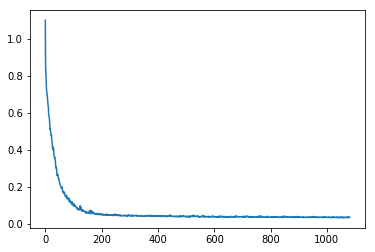

In [26]:
plt.plot(training_loss_list)